In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
warnings.filterwarnings("ignore")
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

In [2]:
# 분석

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [4]:
df = pd.read_csv('유방암_refined.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df[:5]

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,texture_se,compactness_se,concave points_se,symmetry_worst
0,1,17.99,10.38,0.11840,0.244983,0.2419,0.075766,0.644639,1.445762,0.813429,2.275102
1,1,20.57,17.77,0.08474,0.075701,0.1812,0.055122,0.550373,-0.797281,0.421999,-0.127908
2,1,19.69,21.25,0.10960,0.148334,0.2069,0.058259,0.580482,1.124420,1.449930,1.243003
3,1,11.42,20.38,0.14250,0.249902,0.2597,0.092980,0.768255,1.960240,1.207808,2.498841
4,1,20.29,14.34,0.10030,0.124692,0.1809,0.057165,0.577343,0.258638,1.231515,-0.959691


In [5]:
# 1. 데이터 로드 및 전처리
X = df.drop('diagnosis', axis=1) #feature
y = df['diagnosis'] #target

# 2. 학습용/테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 10) (114, 10) (455,) (114,)


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def display_plots(y_true, y_pred, pred_proba=None):
	# confusion matrix
	cm = confusion_matrix(y_true, y_pred)
	display_labels = ['M', 'B']
	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
	disp.plot(cmap='Blues')
	plt.show()

	# roc
	fpr, tpr, thresholds = roc_curve(y_true, y_pred)
	auc = roc_auc_score(y_true, y_pred)

	plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
	plt.plot([0,1],[0,1],'k--')
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('ROC Curve')
	plt.legend()
	plt.show()

In [8]:
def display_plots_2(model, y_true, y_pred, pred_proba=None):
	# 정확도 및 F1 계산
	accuracy = accuracy_score(y_true, y_pred)
	f1 = f1_score(y_true, y_pred)

	# 시각화
	metrics = ['Accuracy', 'F1 Score']
	scores = [accuracy, f1]

	plt.figure(figsize=(6, 4))
	bars = plt.bar(metrics, scores)

	# 각 막대 위에 점수 표시
	for bar, score in zip(bars, scores):
			yval = bar.get_height()
			plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{score:.4f}', ha='center', va='bottom')

	plt.ylim(0, 1)
	plt.title(f'{model.__class__.__name__}의 F1 및 Accuracy Score')
	plt.ylabel('Score')
	plt.show()


In [9]:
def get_score(y_test, y_pred):
	roc_auc = roc_auc_score(y_test, y_pred)
	accuracy = accuracy_score(y_test, y_pred)
	f1 = f1_score(y_test, y_pred)

	print("ROC AUC Score:",roc_auc)
	print("Accuracy:",accuracy)
	print("F1 Score:",f1)

In [10]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def display_learning_curves(x, y, model):
   train_sizes, train_scores, val_scores = learning_curve(
      estimator=model, X=x, y=y, cv=5, scoring='accuracy'
   )

   train_mean = train_scores.mean(axis=1)
   val_mean   = val_scores.mean(axis=1)

   plt.plot(train_sizes, train_mean, label='Train score')
   plt.plot(train_sizes, val_mean, label='Validation score')
   plt.xlabel('Training size')
   plt.ylabel('Accuracy')
   plt.title('Learning Curve')
   plt.legend()
   plt.grid(True)
   plt.show()

In [11]:
# Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression 모델 학습
lgrg_clf = LogisticRegression()
lgrg_clf.fit(X_train, y_train)

# 예측
y_pred = lgrg_clf.predict(X_test)

# 예측 확률
pred_proba = lgrg_clf.predict_proba(X_test)

get_score(y_test, y_pred)

ROC AUC Score: 0.9580740255486406
Accuracy: 0.9649122807017544
F1 Score: 0.9523809523809523


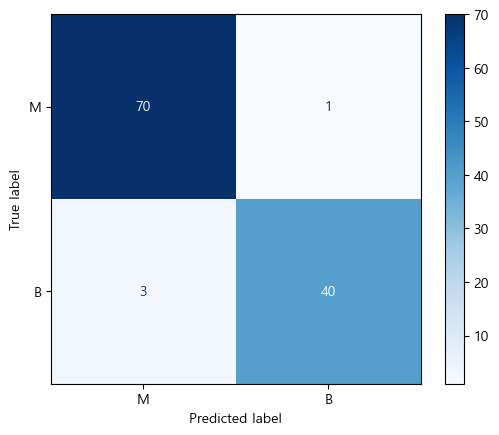

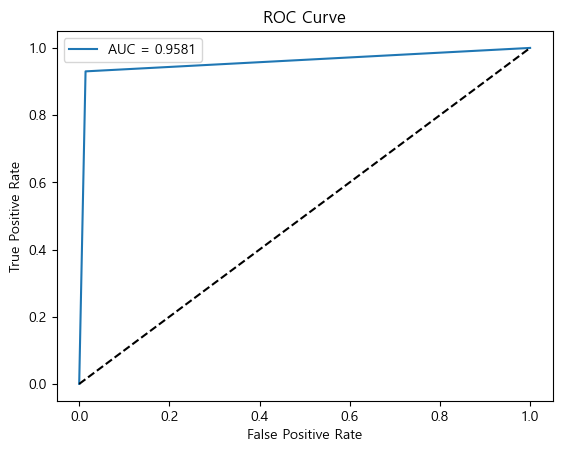

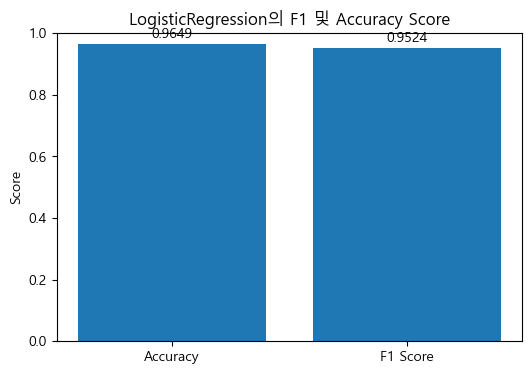

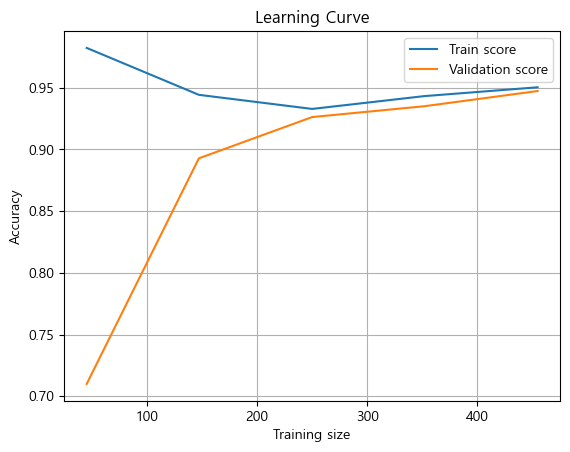

In [13]:
display_plots(y_test, y_pred, pred_proba)
display_plots_2(lgrg_clf, y_test, y_pred, pred_proba)
display_learning_curves(X, y, lgrg_clf)

In [14]:
lgrg_clf = LogisticRegression()

param_grid = {
    'max_iter': [100, 200],
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(lgrg_clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 정확도 (CV 기준):", grid_search.best_score_)

best_model = grid_search.best_estimator_
lgrg_y_pred = best_model.predict(X_test)

get_score(y_test, lgrg_y_pred)

최적 하이퍼파라미터: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
최고 정확도 (CV 기준): 0.9831604181022351
ROC AUC Score: 0.9510317720275139
Accuracy: 0.956140350877193
F1 Score: 0.9411764705882353


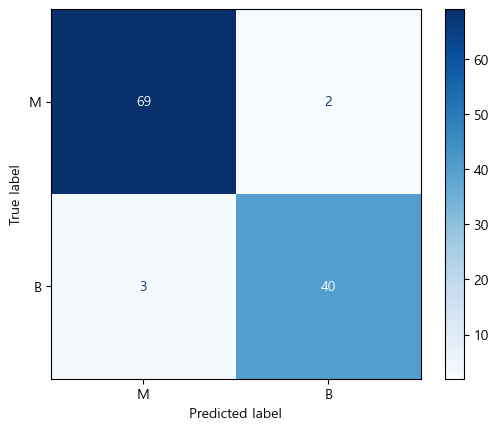

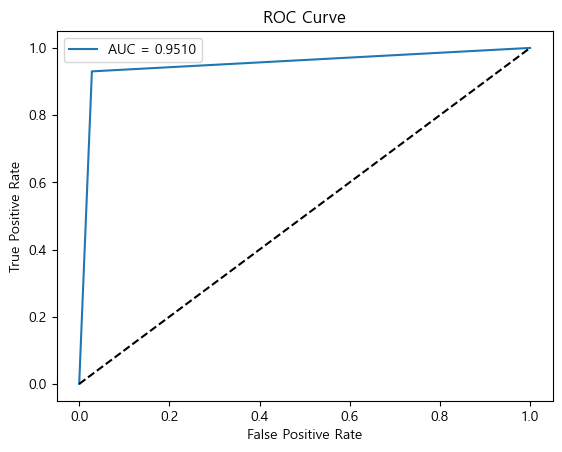

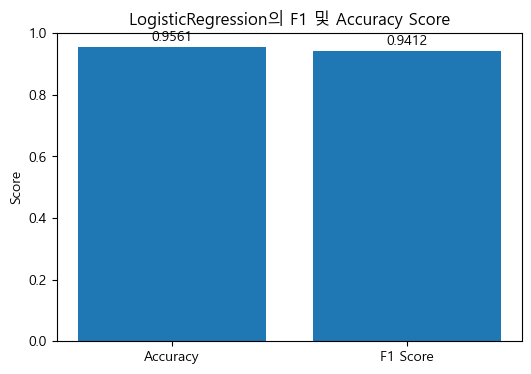

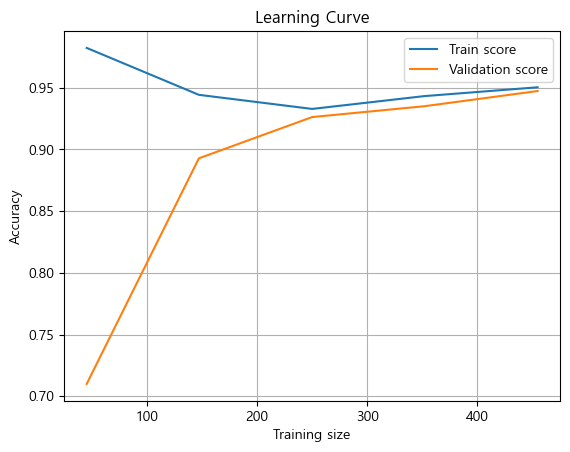

In [15]:
display_plots(y_test, lgrg_y_pred, pred_proba)
display_plots_2(lgrg_clf, y_test, lgrg_y_pred, pred_proba)
display_learning_curves(X, y, lgrg_clf)

In [16]:
# KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

pred_proba = knn_clf.predict_proba(X_test)

get_score(y_test, y_pred)

ROC AUC Score: 0.8879790370127744
Accuracy: 0.8947368421052632
F1 Score: 0.8604651162790697


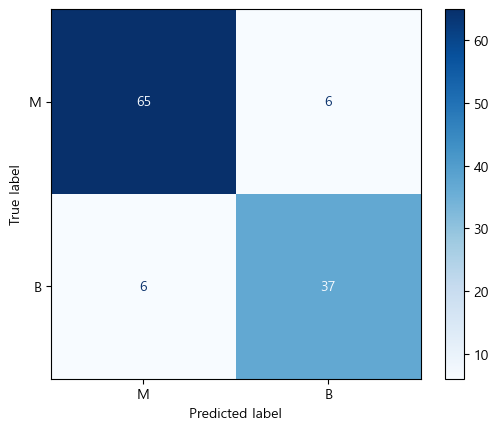

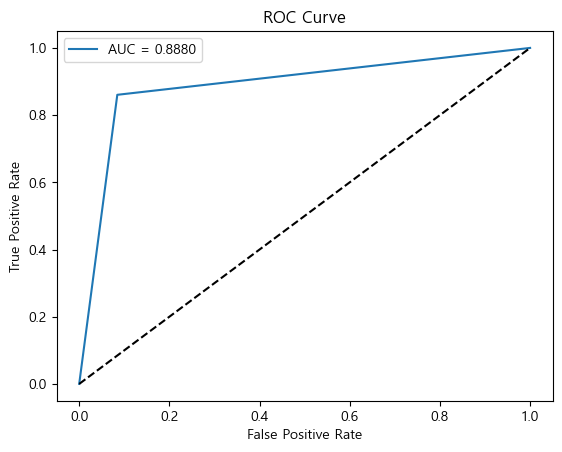

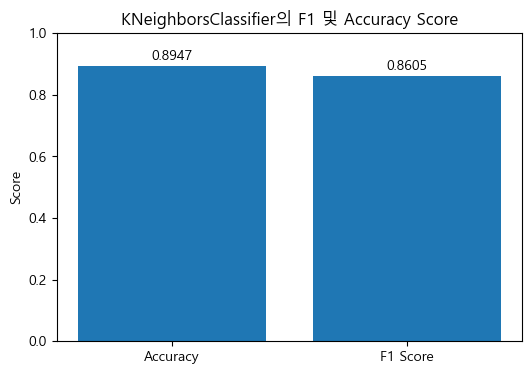

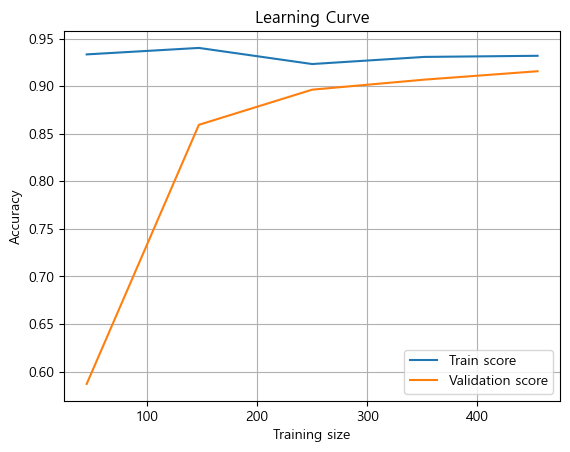

In [18]:
display_plots(y_test, y_pred, pred_proba)
display_plots_2(knn_clf, y_test, y_pred, pred_proba)
display_learning_curves(X, y, knn_clf)

In [19]:
knn_clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'p': [1, 2]
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 정확도 (CV 기준):", grid_search.best_score_)

best_model = grid_search.best_estimator_
knn_y_pred = best_model.predict(X_test)

get_score(y_test, knn_y_pred)

최적 하이퍼파라미터: {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
최고 정확도 (CV 기준): 0.9589010096696656
ROC AUC Score: 0.8879790370127744
Accuracy: 0.8947368421052632
F1 Score: 0.8604651162790697


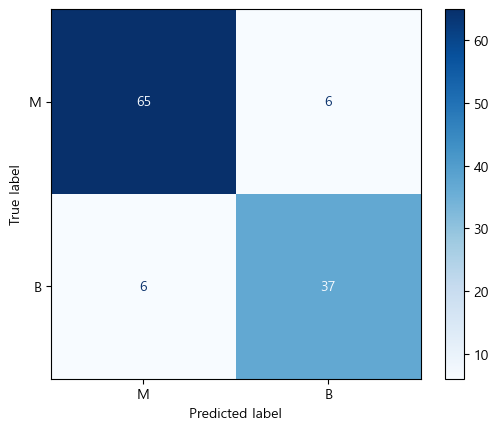

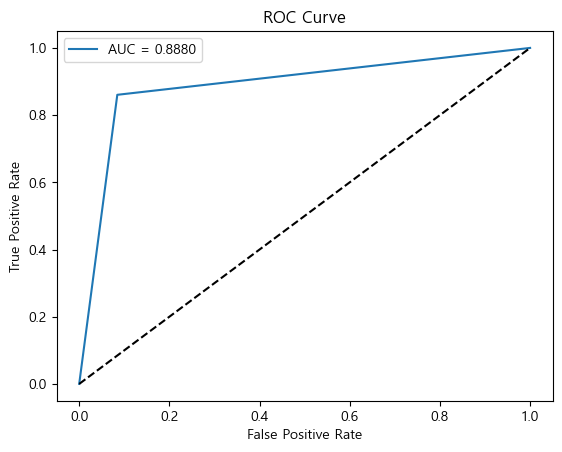

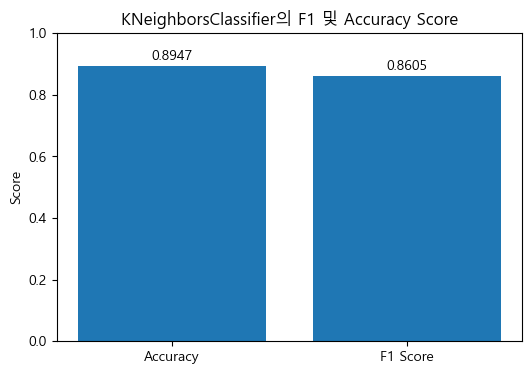

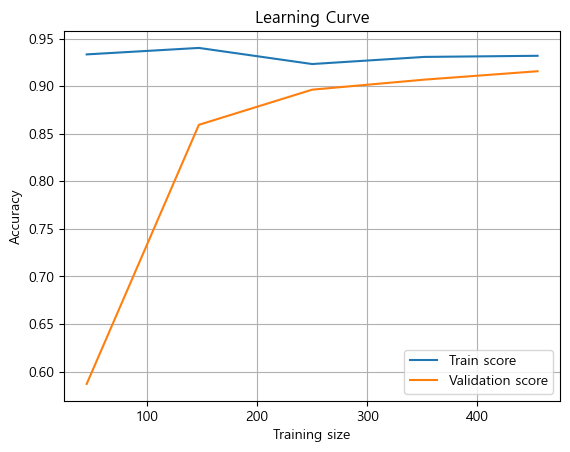

In [20]:
display_plots(y_test, knn_y_pred, pred_proba)
display_plots_2(knn_clf, y_test, knn_y_pred, pred_proba)
display_learning_curves(X, y, knn_clf)

In [21]:
# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

pred_proba = dt_clf.predict_proba(X_test)

get_score(y_test, y_pred)

ROC AUC Score: 0.9133639043563707
Accuracy: 0.9035087719298246
F1 Score: 0.8817204301075269


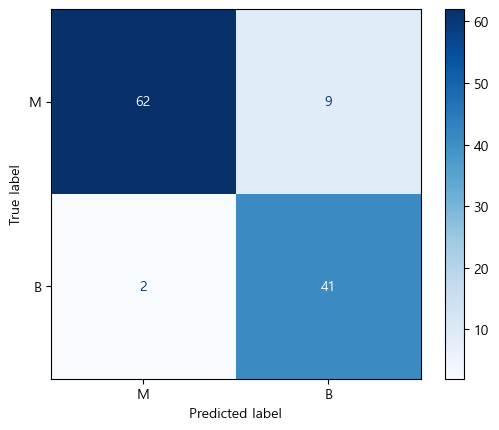

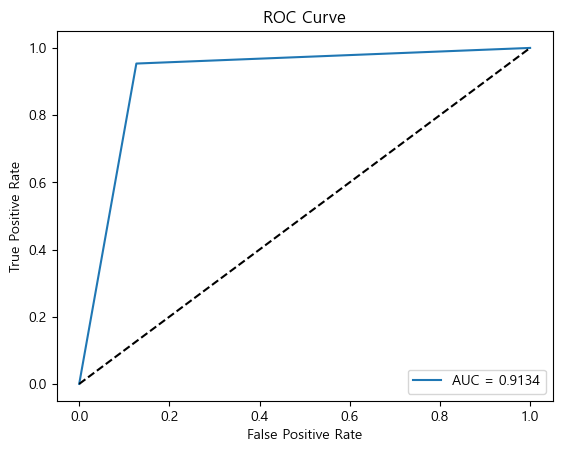

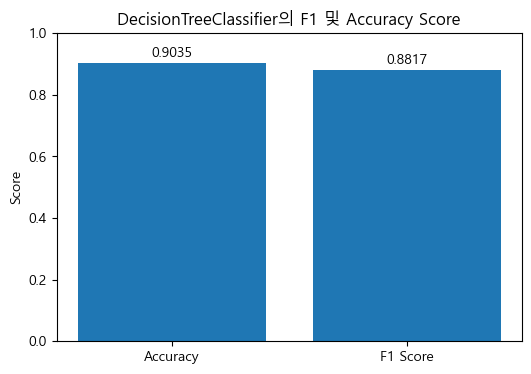

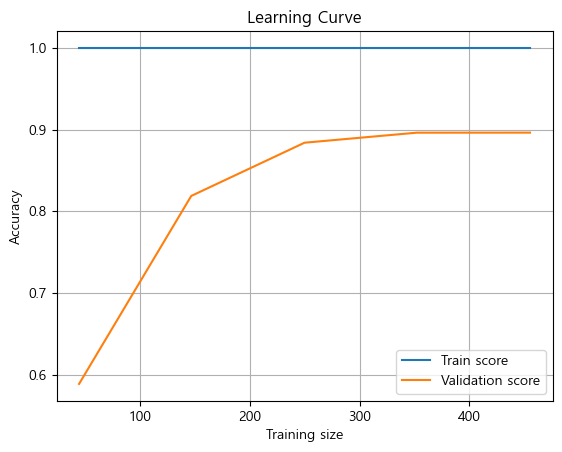

In [23]:
display_plots(y_test, y_pred, pred_proba)
display_plots_2(dt_clf, y_test, y_pred, pred_proba)
display_learning_curves(X, y, dt_clf)

In [24]:
dt_clf = DecisionTreeClassifier(random_state=42)

param_grid = {
	'max_depth': [3, 5, 7, None],
	'min_samples_split': [2, 5, 10],
	'criterion': ['gini', 'entropy'],
	'min_samples_leaf': [1, 2, 4],
	'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                           param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 정확도 (CV 기준):", grid_search.best_score_)

best_model = grid_search.best_estimator_
dt_y_pred = best_model.predict(X_test)

get_score(y_test, dt_y_pred)

최적 하이퍼파라미터: {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
최고 정확도 (CV 기준): 0.952008825308708
ROC AUC Score: 0.9136914510317721
Accuracy: 0.9210526315789473
F1 Score: 0.8941176470588236


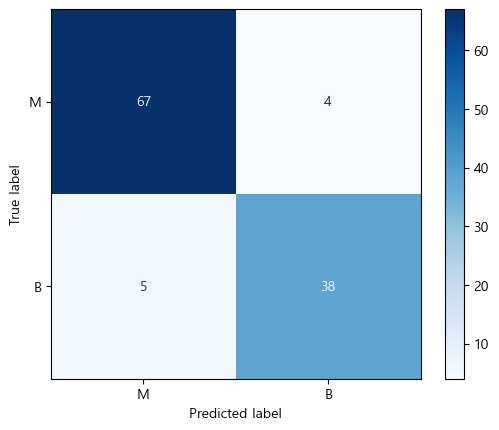

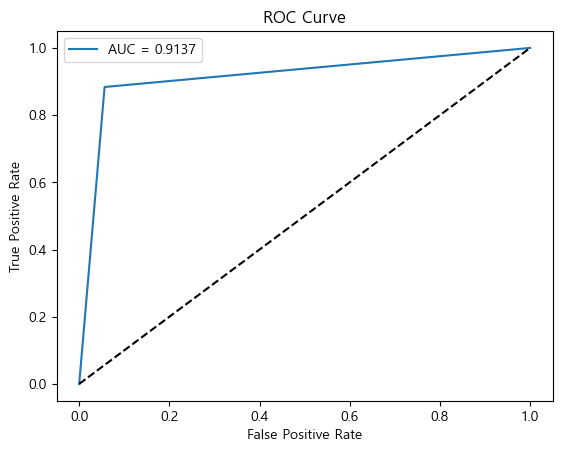

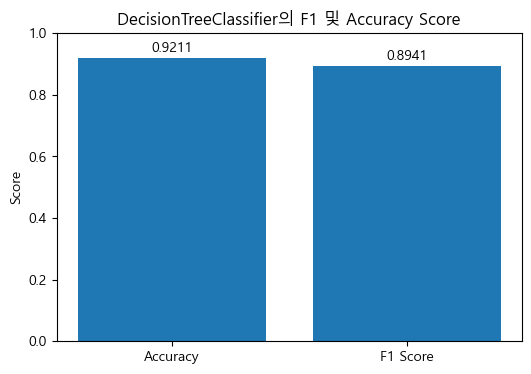

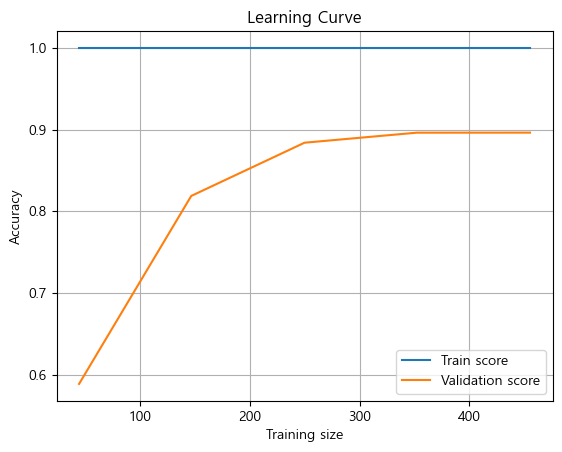

In [25]:
display_plots(y_test, dt_y_pred, pred_proba)
display_plots_2(dt_clf, y_test, dt_y_pred, pred_proba)
display_learning_curves(X, y, dt_clf)

In [26]:
# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

pred_proba = rf_clf.predict_proba(X_test)

get_score(y_test, y_pred)

ROC AUC Score: 0.9439895185063871
Accuracy: 0.9473684210526315
F1 Score: 0.9302325581395349


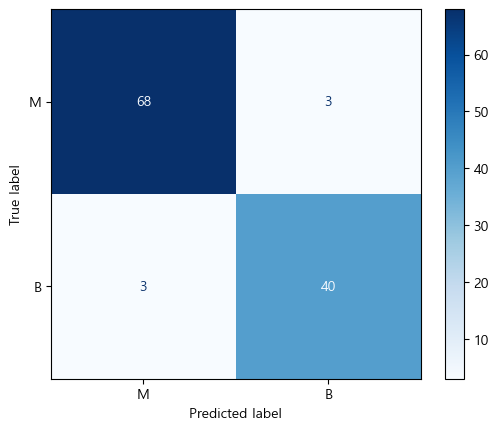

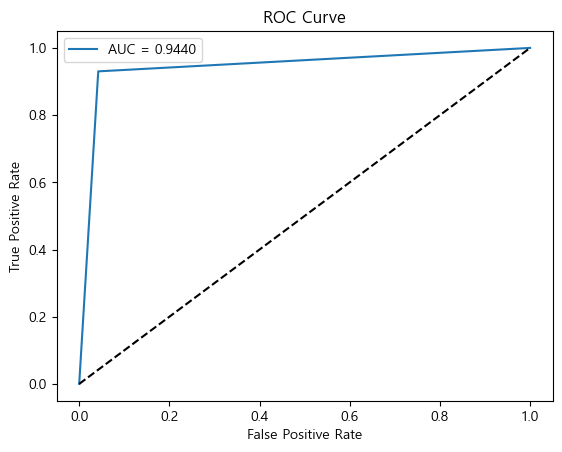

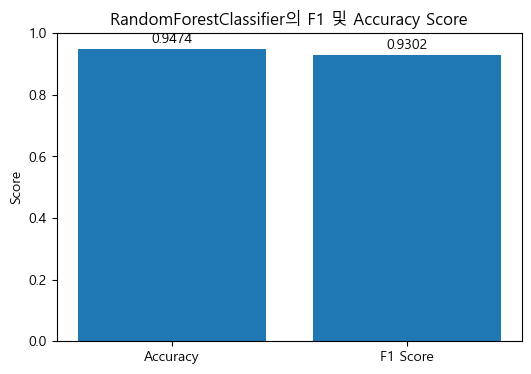

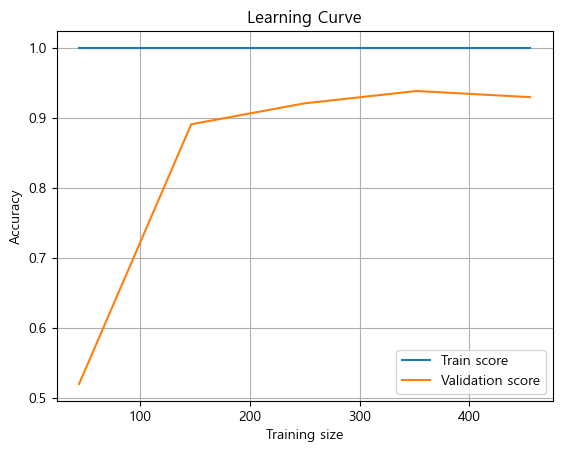

In [28]:
display_plots(y_test, y_pred, pred_proba)
display_plots_2(rf_clf, y_test, y_pred, pred_proba)
display_learning_curves(X, y, rf_clf)

In [29]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
	'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 정확도 (CV 기준):", grid_search.best_score_)

best_model = grid_search.best_estimator_
rf_y_pred = best_model.predict(X_test)

get_score(y_test, rf_y_pred)

최적 하이퍼파라미터: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
최고 정확도 (CV 기준): 0.9824432000155283
ROC AUC Score: 0.9394038650507697
Accuracy: 0.9473684210526315
F1 Score: 0.9285714285714286


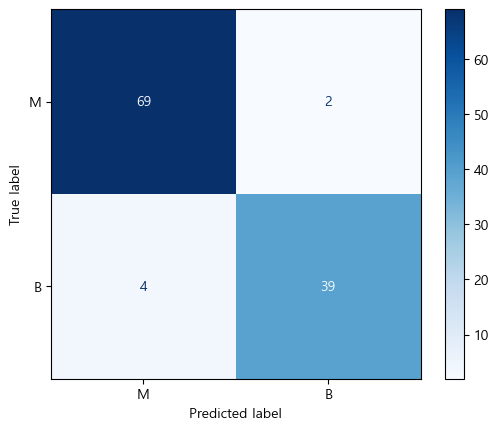

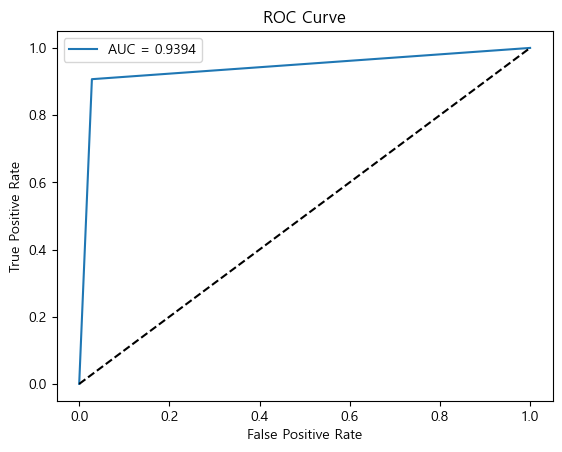

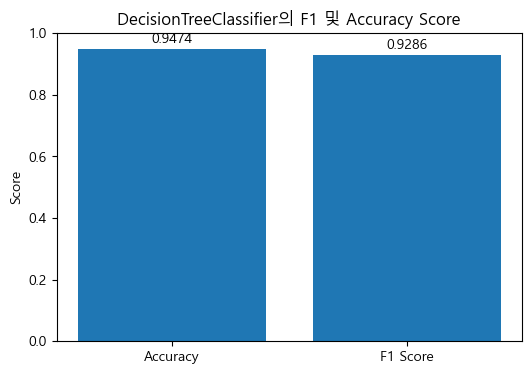

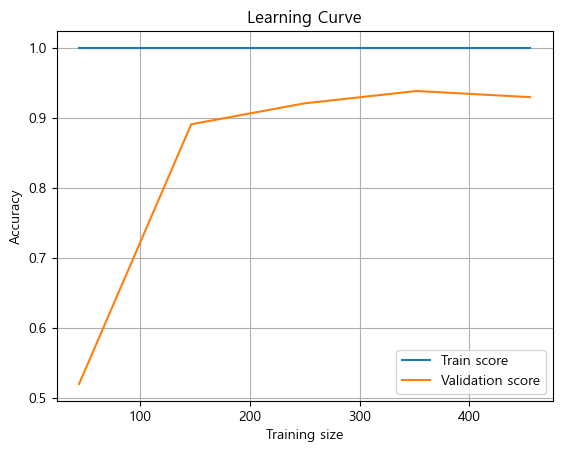

In [30]:
display_plots(y_test, rf_y_pred, pred_proba)
display_plots_2(dt_clf, y_test, rf_y_pred, pred_proba)
display_learning_curves(X, y, rf_clf)

In [31]:
# 튜닝전

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


results = {}

models = {
	"Logistic Classifier": LogisticRegression(),
	"KNN Classifier": KNeighborsClassifier(),
	"Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
	"RandomForest Classifier": RandomForestClassifier(random_state=42)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = format(roc_auc_score(y_test, y_pred), '.4f')
    accuracy = format(accuracy_score(y_test, y_pred), '.4f')
    f1 = format(f1_score(y_test, y_pred), '.4f')
    results[name] = {'ROC_AUC':roc_auc,'Accuracy': accuracy, 'F1': f1}

In [33]:
# 결과 출력
results_df = pd.DataFrame(results).T
print(results_df)

                         ROC_AUC Accuracy      F1
Logistic Classifier       0.9581   0.9649  0.9524
KNN Classifier            0.8880   0.8947  0.8605
Decision Tree Classifier  0.9134   0.9035  0.8817
RandomForest Classifier   0.9440   0.9474  0.9302


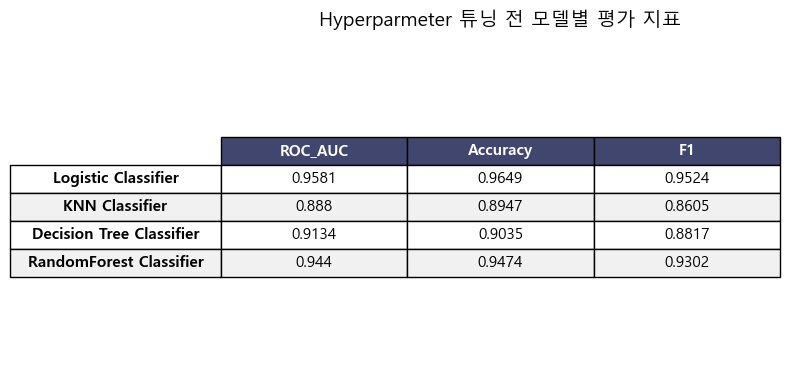

In [34]:
# 결과 정렬
results_sorted = results_df

# 'MAE', 'RMSE', 'R2' 열을 float으로 변환
results_sorted['ROC_AUC'] = pd.to_numeric(results_sorted['ROC_AUC'], errors='coerce')
results_sorted['Accuracy'] = pd.to_numeric(results_sorted['Accuracy'], errors='coerce')
results_sorted['F1'] = pd.to_numeric(results_sorted['F1'], errors='coerce')

# 플롯 사이즈 지정
fig, ax = plt.subplots(figsize=(8, 4))  # 표 크기 조절 가능

# x, y 축 숨기기
ax.axis('off')

# 테이블 추가
table = ax.table(cellText=np.round(results_sorted.values,4),
                 colLabels=results_sorted.columns,
                 rowLabels=results_sorted.index,
                 cellLoc='center',
                 rowLoc='center',
                 loc='center')

table.scale(1, 1.5)  # 셀 크기 조절
table.auto_set_font_size(False)
table.set_fontsize(11)

# 셀 배경색 (헤더 강조)
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')
    if row == 0:
        cell.set_facecolor('#40466e')  # 헤더 배경
        cell.set_text_props(color='w')  # 헤더 텍스트 색
    elif row % 2 == 0:
        cell.set_facecolor('#f1f1f2')  # 짝수행 배경
    else:
        cell.set_facecolor('#ffffff')  # 홀수행 배경

plt.title("Hyperparmeter 튜닝 전 모델별 평가 지표", fontsize=14)
plt.tight_layout()
plt.show()


In [35]:
results_sorted_dict = results_sorted.T.to_dict()
results_sorted_dict

{'Logistic Classifier': {'ROC_AUC': 0.9581, 'Accuracy': 0.9649, 'F1': 0.9524},
 'KNN Classifier': {'ROC_AUC': 0.888, 'Accuracy': 0.8947, 'F1': 0.8605},
 'Decision Tree Classifier': {'ROC_AUC': 0.9134,
  'Accuracy': 0.9035,
  'F1': 0.8817},
 'RandomForest Classifier': {'ROC_AUC': 0.944,
  'Accuracy': 0.9474,
  'F1': 0.9302}}

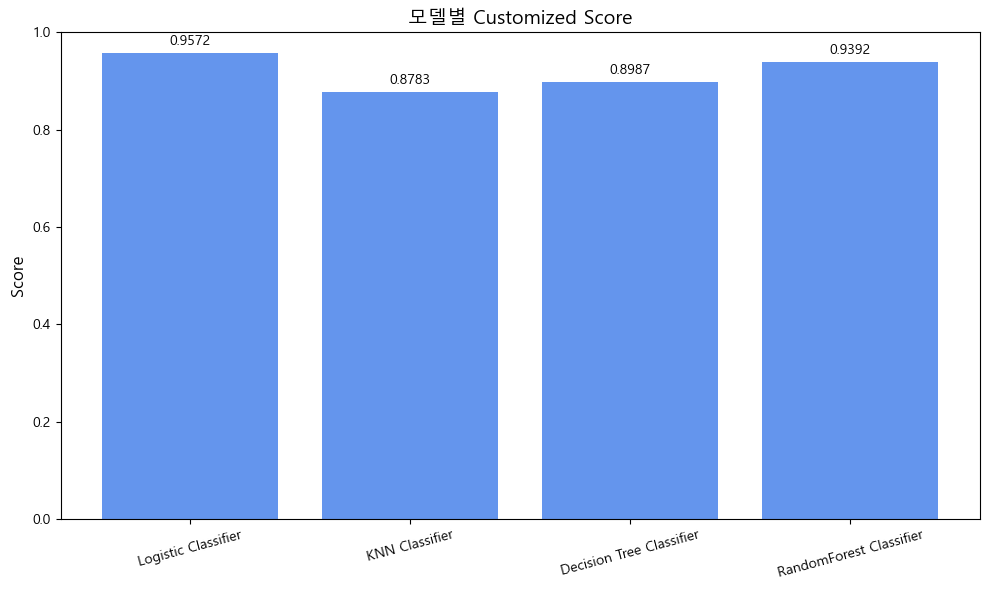

In [36]:
# score = 1 - (0.2 * (MAE / IQR) + 0.2 * (RMSE / IQR) + 0.6 * (1 - R²))
def calculate_custom_score(auc, accuracy, f1):
    """
    사용자 정의 분류 성능 스코어 계산 함수.
    auc, accuracy, f1 score를 가중평균내어 계산함
    
    Parameters:
    - auc, accuracy, f1

    Returns:
    - custom_score: 0~1 사이의 스코어, 1에 가까울수록 성능이 우수
    """
    return 0.4 * f1 + 0.4 * auc + 0.2 * accuracy

scores = {}
for model, metrics in results_sorted_dict.items():
    score = calculate_custom_score(metrics["ROC_AUC"], metrics["Accuracy"], metrics["F1"])
    scores[model] = score
    
# 막대그래프 시각화
models = list(scores.keys())
score_values = list(scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, score_values, color='cornflowerblue')
plt.title("모델별 Customized Score", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [37]:
# 튜닝후

In [38]:
results_dict = {}
def get_mse_r2score_all(model, y_test, y_pred,model_name):
    if hasattr(model, 'coef_'):
        print("계수 (coef_):\n", model.coef_)
        print("절편 (intercept):", model.intercept_)
    else:
        print("이 모델은 계수(coef_)와 절편(intercept_)을 제공하지 않습니다.")

    roc_auc = format(roc_auc_score(y_test, y_pred), '.4f')
    accuracy = format(accuracy_score(y_test, y_pred), '.4f')
    f1 = format(f1_score(y_test, y_pred), '.4f')

    print("평균절대오차 (ROC_AUC):", roc_auc)
    print("평균제곱근오차 (Accuracy):", accuracy)
    print("결정계수 (R² Score):", f1)

    results_dict[model_name] = {'ROC_AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1}
    return roc_auc, accuracy, f1

In [39]:
models = {
	"Logistic Classifier": LogisticRegression(C=200, max_iter=100, penalty='l1', solver='liblinear'),
	"KNN Classifier": KNeighborsClassifier(metric='manhattan', n_neighbors=7, p=1, weights='distance'),
	"Decision Tree Classifier": DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10),
	"RandomForest Classifier": RandomForestClassifier(random_state=42, max_depth=7, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
}

In [40]:
results_dict = {}
def get_mse_r2score_all(model, y_test, y_pred,model_name):

    roc_auc = format(roc_auc_score(y_test, y_pred), '.4f')
    accuracy = format(accuracy_score(y_test, y_pred), '.4f')
    f1 = format(f1_score(y_test, y_pred), '.4f')

    print("평균절대오차 (ROC_AUC):", roc_auc)
    print("평균제곱근오차 (Accuracy):", accuracy)
    print("결정계수 (R² Score):", f1)

    results_dict[model_name] = {'ROC_AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1}
    return roc_auc, accuracy, f1


In [41]:
for name, model in models.items():
	print(f"\n▶ {name} 결과:")
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)
	get_mse_r2score_all(model, y_test, y_pred,name)



▶ Logistic Classifier 결과:
평균절대오차 (ROC_AUC): 0.9510
평균제곱근오차 (Accuracy): 0.9561
결정계수 (R² Score): 0.9412

▶ KNN Classifier 결과:
평균절대오차 (ROC_AUC): 0.9299
평균제곱근오차 (Accuracy): 0.9298
결정계수 (R² Score): 0.9091

▶ Decision Tree Classifier 결과:
평균절대오차 (ROC_AUC): 0.9112
평균제곱근오차 (Accuracy): 0.9123
결정계수 (R² Score): 0.8864

▶ RandomForest Classifier 결과:
평균절대오차 (ROC_AUC): 0.9394
평균제곱근오차 (Accuracy): 0.9474
결정계수 (R² Score): 0.9286


In [42]:
results_df = pd.DataFrame(results_dict).T
print(results_df)

                         ROC_AUC Accuracy      F1
Logistic Classifier       0.9510   0.9561  0.9412
KNN Classifier            0.9299   0.9298  0.9091
Decision Tree Classifier  0.9112   0.9123  0.8864
RandomForest Classifier   0.9394   0.9474  0.9286


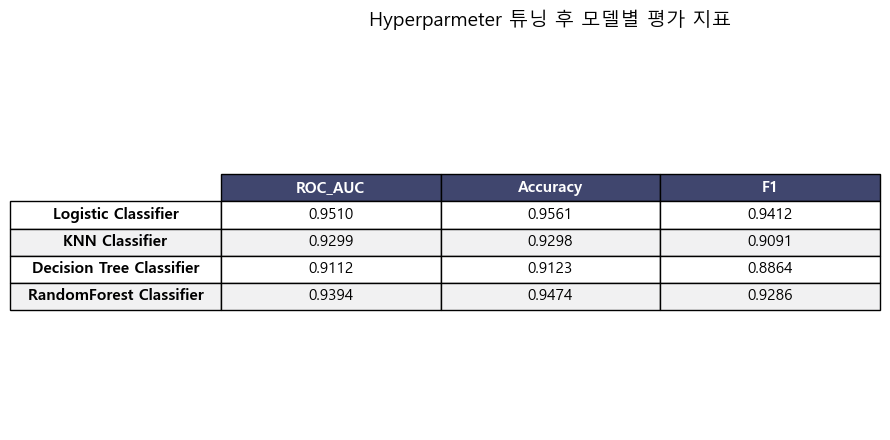

In [43]:
import matplotlib.pyplot as plt

# 결과 정렬
results_sorted = results_df

# 테이블 시각화
fig, ax = plt.subplots(figsize=(9, 4.5))  # 전체 도표 크기

# 축 숨기기
ax.axis('off')

# 테이블 만들기
table = ax.table(
    cellText=results_sorted.values,  # 소수점 2자리 반올림
    colLabels=results_sorted.columns,
    rowLabels=results_sorted.index,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)

# 셀 크기 및 폰트 조정
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(11)

# 셀 배경색 (헤더 강조)
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')
    if row == 0:
        cell.set_facecolor('#40466e')  # 헤더 배경
        cell.set_text_props(color='w')  # 헤더 텍스트 색
    elif row % 2 == 0:
        cell.set_facecolor('#f1f1f2')  # 짝수행 배경
    else:
        cell.set_facecolor('#ffffff')  # 홀수행 배경

plt.title("Hyperparmeter 튜닝 후 모델별 평가 지표", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [44]:
results_sorted_dict = results_sorted.T.to_dict()
results_sorted_dict

{'Logistic Classifier': {'ROC_AUC': '0.9510',
  'Accuracy': '0.9561',
  'F1': '0.9412'},
 'KNN Classifier': {'ROC_AUC': '0.9299', 'Accuracy': '0.9298', 'F1': '0.9091'},
 'Decision Tree Classifier': {'ROC_AUC': '0.9112',
  'Accuracy': '0.9123',
  'F1': '0.8864'},
 'RandomForest Classifier': {'ROC_AUC': '0.9394',
  'Accuracy': '0.9474',
  'F1': '0.9286'}}

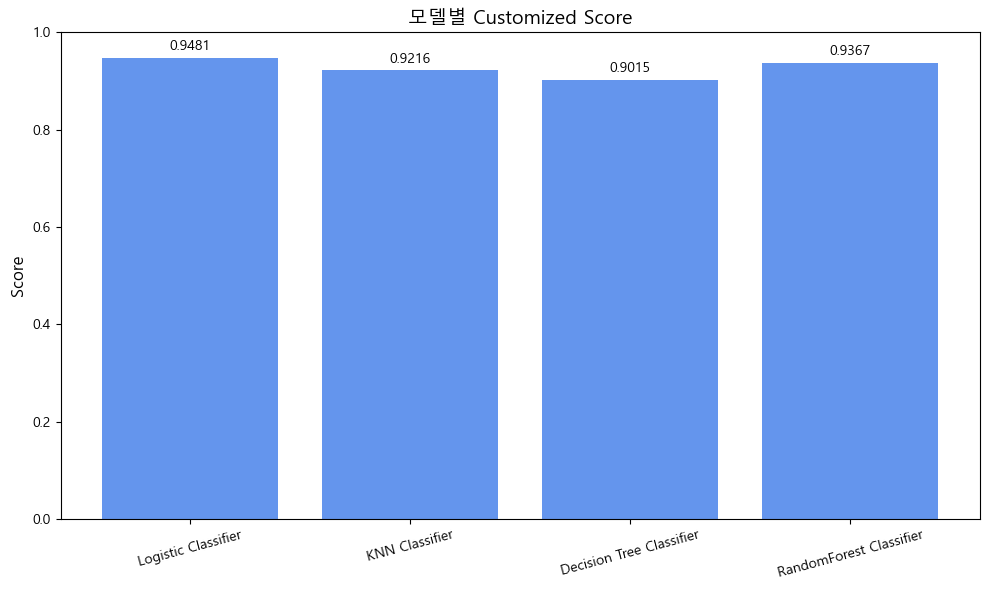

In [45]:
# score = 1 - (0.2 * (MAE / IQR) + 0.2 * (RMSE / IQR) + 0.6 * (1 - R²))
def calculate_custom_score(auc, accuracy, f1):
    """
    사용자 정의 분류 성능 스코어 계산 함수.
    auc, accuracy, f1 score를 가중평균내어 계산함
    
    Parameters:
    - auc, accuracy, f1

    Returns:
    - custom_score: 0~1 사이의 스코어, 1에 가까울수록 성능이 우수
    """
    auc = float(auc)
    accuracy = float(accuracy)
    f1 = float(f1)
    return 0.4 * f1 + 0.4 * auc + 0.2 * accuracy

scores = {}
for model, metrics in results_sorted_dict.items():
    score = calculate_custom_score(metrics["ROC_AUC"], metrics["Accuracy"], metrics["F1"])
    scores[model] = score
    
# 막대그래프 시각화
models = list(scores.keys())
score_values = list(scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, score_values, color='cornflowerblue')
plt.title("모델별 Customized Score", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()